This notebook contains our baseline model for the G1 Deep Learning Image Classification project.

**Team:** Benjamin Hunt, Rodrigo Torralba, Santiago Baron, Bianca

Over the next 3 days, we will iterate on this baseline by testing different model architectures and training setups, then compare results to understand performance trade-offs and extract key findings. Final results will be summarized in a spreadsheet and presented at the end of the project.

Loading the dataset: CIFAR-10

In [57]:
from keras.backend import clear_session  # This is to clear any previous session to prevent reusing old data from  other cells etc.
clear_session()

In [58]:
import numpy as np  # Import libraries like CIFAR-10, Numpys and pandas etc.
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential

from sklearn.metrics import confusion_matrix
import seaborn as sns

In [59]:
# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data() # (Training set: 50,000) - (Test set: 10,000) This will remain untouched until the final evaluation.

Visualize the data : We display a few images per class to understand what the model must learn.  

<Figure size 393.701x393.701 with 0 Axes>

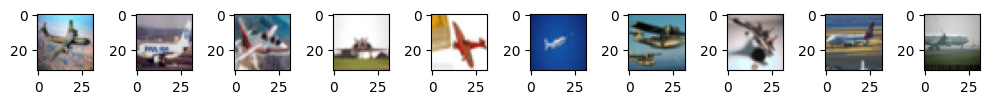

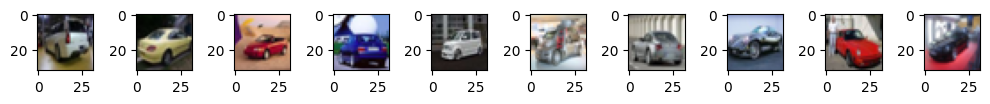

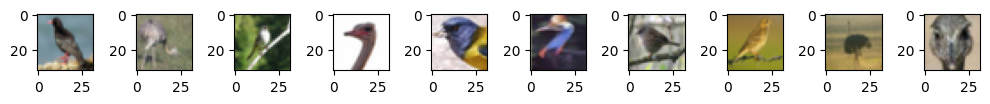

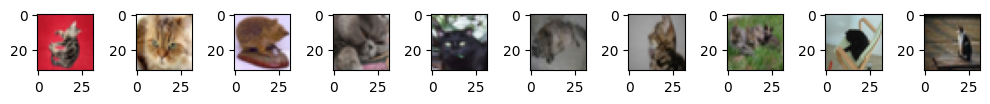

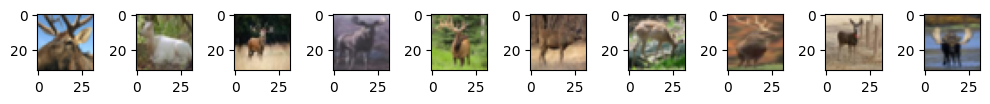

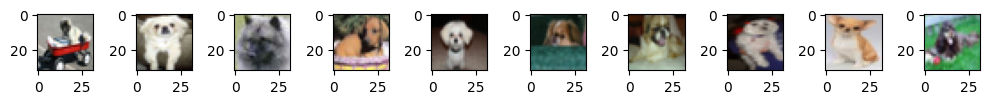

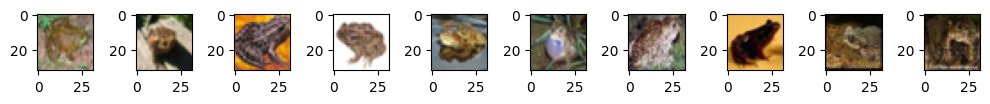

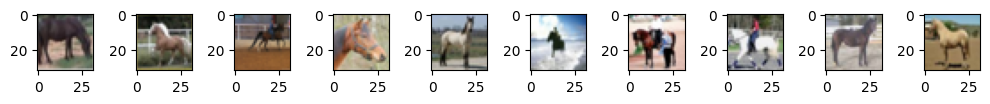

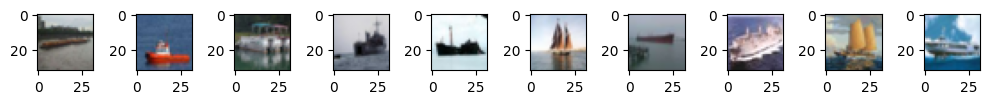

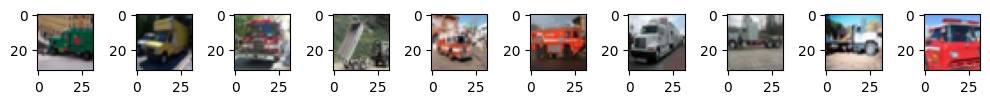

In [60]:

# print(x_train.shape) (check model shape)


num_classes = 10

fig = plt.figure(figsize=(10*1/2.54, 10*1/2.54)) # class to img plot ratio.

for idx_class in range(num_classes): # This section loops through class labels and shows sample images so we can check the dataset format and variety.

  all_idx = np.where(y_train.flatten() == idx_class)[0]

  # random selection of 10 image of each category
  rand_idx = np.random.choice(all_idx, size=10, replace=False)
  selected = x_train[rand_idx]

  plt.figure(figsize=(10, 10))

  for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(selected[i])
    plt.tight_layout()

  plt.show()

Data normalization

In [61]:
x_train = x_train.astype("float32") / 255 # neural networks train more stable when they are converted to [ 0 - 1 ], Here it is done with .astype function to normalize the code from [ 0 - 255 ].
x_test = x_test.astype("float32") / 255

print(x_train.shape)
print(x_test.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


Prepare the labels

In [62]:
y_train = to_categorical(y_train, num_classes=10) # Prepare the labels as they class from 0 - 9, this is ideal for catagorical crossentropy.
y_test = to_categorical(y_test, num_classes=10)

print(y_train.shape) # Here you casn see our train size and test size.
print(y_test.shape)

(50000, 10)
(10000, 10)


In [63]:
from sklearn.model_selection import train_test_split
import numpy as np

# split out data into train/validation, to make sure each split has the same class balance as the original dataset.
y_train_labels = np.argmax(y_train, axis=1)

x_tr, x_val, y_tr, y_val = train_test_split( # explicitly train the model.
    x_train, y_train,
    test_size=0.1, # explcitly remove 10% for test.
    random_state=42, # random, shuffled state set before running our test.
    stratify=y_train_labels # here we create our one hot labels.
)

print("x_tr:", x_tr.shape, "x_val:", x_val.shape) # how does our data set structure look like after the split?
print("y_tr:", y_tr.shape, "y_val:", y_val.shape)

x_tr: (45000, 32, 32, 3) x_val: (5000, 32, 32, 3)
y_tr: (45000, 10) y_val: (5000, 10)


In [71]:
import tensorflow as tf
from tensorflow.keras import layers

data_augmentation = tf.keras.Sequential([ # Not used in final baseline. We use imported callbacks below for overfitting handling.
    layers.RandomFlip("horizontal"),
    layers.RandomTranslation(0.1, 0.1),
    layers.RandomZoom(0.1),
], name="data_augmentation")

Define the first model

In [65]:
input_shape = (32, 32, 3)

model1 = Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3,3), activation='relu'), # Cov2D Learns small visual features (edges/patterns)

        layers.MaxPooling2D(pool_size=(2,2)), # MaxPooling2D reduces spacial size and helps generalize the data.

        layers.Flatten(), # This will convert feature maps into 1 dimension.

        layers.Dense(100, activation='relu'), # 100 Neural nodes in a single layer that are activiated using relu.
        layers.Dense(num_classes, activation="softmax") # Softmax is used to output the probabilties for the 10 classes in this data set.
    ]
)

model1.summary() # preview a nice summery of our model.

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 7200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │       720,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 722,006 (2.75 MB)

 Trainable params: 722,006 (2.75 MB)

 Non-trainable params: 0 (0.00 B)

In [66]:
import time # Track time for deeper statistics.
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau # imported to prevent overfitting

# Compile the model before training
model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# callbacks to watch the behaviour between val and test to ensure they dont get to far apart, thus prevents over fitting.
early_stop = EarlyStopping(
    monitor="val_accuracy",
    patience=5,                 # stop after 5 epochs with no val_acc improvement
    restore_best_weights=True   # revert weights to best val_acc epoch
)

reduce_lr = ReduceLROnPlateau(  # When the val loss no longer improves. (lower is better), If it detects this, it shrinks the learning rate, letting the model take smaller steps to potentially improve further.
    monitor="val_loss",  # watch validation loss.
    factor=0.5,   # When its triggered multiply learning rate by 0.5
    patience=2,   # if validation loss doesnt improve in 2 epochs in a row, trigger the reduction.
    min_lr=1e-5,   # Dont reduce learning rate below 0.00001
    verbose=1   # print one line at a time per epoch.
)

def format_seconds(s: float) -> str: # a function to improve readabilty of the results in the tests.
    s = max(0.0, float(s))  # safety guard to make sure the value is a float and doesnt go negative.
    m, sec = divmod(s, 60) # m = minutes, sec = seconds. Convertion.
    h, m = divmod(m, 60) # h = hours, m = remaining minutes
    if h >= 1:
        return f"{int(h)}h {int(m)}m {sec:.2f}s"
    if m >= 1:
        return f"{int(m)}m {sec:.2f}s"
    return f"{sec:.2f}s"



history1 = model1.fit(
    x_tr, y_tr,
    validation_data=(x_val, y_val),  # validation set is taken from training data only
    epochs=40, # High number of Epochs to show our over fitting preventing calls backs work.
    batch_size=64, #
    callbacks=[early_stop, reduce_lr],
    verbose=1
)




t1 = time.perf_counter() # Measure total training time using a monotonic clock

fit_time = t1 - t0

print(f"Fit time (total): {format_seconds(fit_time)}")




epochs_ran = len(history1.history["loss"])
print("Fit time per epoch (avg):", format_seconds(fit_time / epochs_ran)) # We divide total training time by the number of epochs actually completed.
                                                                          # This matters because EarlyStopping might stop before reaching the max epochs.

print("Train accuracy (last):", history1.history["accuracy"][-1]) # history1.history stores a list of values per epoch.
print("Train loss (last):", history1.history["loss"][-1]) # Using [-1] gives the final epoch value (the last item in the list).

print("Val accuracy (last):", history1.history["val_accuracy"][-1])
print("Val loss (last):", history1.history["val_loss"][-1])



val_acc_best = max(history1.history["val_accuracy"]) # We compute the highest validation accuracy achieved across all epochs.
                                                     # This helps us see the best point during training (often earlier than the final epoch).
best_epoch = 1 + history1.history["val_accuracy"].index(val_acc_best)
print("Val accuracy (best):", val_acc_best, "at epoch", best_epoch)

score = model1.evaluate(x_test, y_test, verbose=0) # The test set (x_test/y_test) was never used during training or validation.
                                                   # This is the true generalization score of the model.
                                                  # model.evaluate returns [loss, accuracy] because we compiled with metrics=['accuracy'].

print("TEST loss:", score[0])
print("TEST accuracy:", score[1])


Epoch 1/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.3808 - loss: 1.7254 - val_accuracy: 0.5538 - val_loss: 1.2779 - learning_rate: 0.0010
Epoch 2/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5677 - loss: 1.2323 - val_accuracy: 0.5924 - val_loss: 1.1727 - learning_rate: 0.0010
Epoch 3/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6140 - loss: 1.0998 - val_accuracy: 0.6086 - val_loss: 1.1333 - learning_rate: 0.0010
Epoch 4/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.6449 - loss: 1.0176 - val_accuracy: 0.6096 - val_loss: 1.1077 - learning_rate: 0.0010
Epoch 5/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6725 - loss: 0.9427 - val_accuracy: 0.6118 - val_loss: 1.1204 - learning_rate: 0.0010
Epoch 6/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6918 - loss: 0.8846 - val_accuracy: 0.6164 - val_loss: 1.0887 - learning_rate: 0.0010
Epoch 7/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7154 - loss: 0.8222 - 

Test loss: 1.106033444404602
Test accuracy: 0.6504999995231628
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


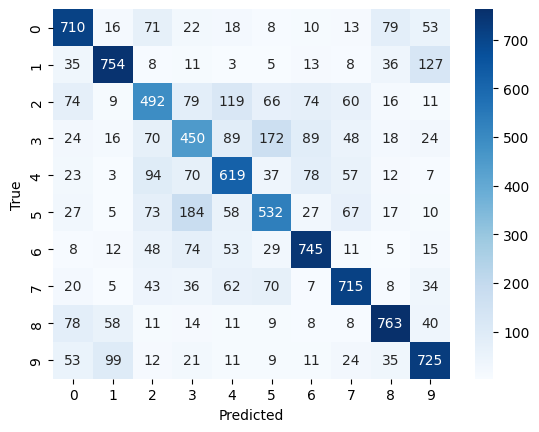

In [67]:
# FINAL TEST EVALUATION
# The test set (x_test/y_test) was never used during training or validation.
# This is the true generalization score of the model.

score = model1.evaluate(x_test, y_test, verbose=0)

print("Test loss:", score[0])     # score[0] = test loss
print("Test accuracy:", score[1]) # score[1] = test accuracy


# prediction for test.

y_test_pred_prob = model1.predict(x_test) # shape: (10000, 10) probabilities for each test image
y_test_pred = y_test_pred_prob.argmax(axis=1) # convert probabilities → predicted class index (0–9)


# Plotting results into confusion matrix

conf_matr = confusion_matrix(np.argmax(y_test, axis=1), y_test_pred)



sns.heatmap(conf_matr, annot=True, fmt='d', cmap='Blues') # Heatmap makes it easier to see where the model performs well (high diagonal)
                                                          # and where it makes systematic mistakes (clusters off-diagonal).

plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [68]:
print(history1.history.keys())
print("Train accuracy:", history1.history["accuracy"][-1])
print("Train loss:", history1.history["loss"][-1])
print("Validation accuracy:", history1.history["val_accuracy"][-1])
print("Validation loss:", history1.history["val_loss"][-1])

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])
Train accuracy: 0.8746222257614136
Train loss: 0.41204261779785156
Validation accuracy: 0.6668000221252441
Validation loss: 1.0561672449111938


In [1]:
import os
print("Working directory:", os.getcwd())
print("Files here:", os.listdir())

# Save full model (best default)
model1.save("cifar10.v1_G1_cnn.keras")


Working directory: /content
Files here: ['.config', 'sample_data']


NameError: name 'model1' is not defined

In [70]:
# Load model syntax

# import tensorflow as tf
# model1 = tf.keras.models.load_model("model1.keras")
# print("Loaded model1.keras")


This concludes Model-1  